In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import pandas as pd
import matplotlib.dates as mdates

In [2]:
output_1h_solar = np.genfromtxt('test_results/outputs_solar_1h.csv', delimiter=',')
output_24h_solar = np.genfromtxt('test_results/solar_outputs_24h.csv', delimiter=',')
output_1h_wind = np.genfromtxt('test_results/wind_outputs_1h.csv', delimiter=',')
output_24h_wind = np.genfromtxt('test_results/outputs_wind_24h.csv', delimiter=',')

target_1h_solar = np.genfromtxt('test_results/targets_solar_1h.csv', delimiter=',')
target_24h_solar = np.genfromtxt('test_results/solar_targets_24h.csv', delimiter=',')
target_1h_wind = np.genfromtxt('test_results/wind_targets_1h.csv', delimiter=',')
target_24h_wind = np.genfromtxt('test_results/targets_wind_24h.csv', delimiter=',')

In [3]:
wind_unnorm = np.genfromtxt('data/test_data/test_wind_unnorm2.csv', delimiter=',',skip_header=1)
#get first column of wind_unnorm
wind_unnorm = wind_unnorm[:,0]
wind_max = np.max(wind_unnorm)
wind_min = np.min(wind_unnorm)
solar_unnorm = np.genfromtxt('data/test_data/test_solar_unnorm2.csv', delimiter=',',skip_header=1)
#get first column of solar_unnorm
solar_unnorm = solar_unnorm[:,0]
solar_max = np.max(solar_unnorm)
solar_min = np.min(solar_unnorm)
print('wind max: ', wind_max, 'wind min: ', wind_min)
print('solar max: ', solar_max, 'solar min: ', solar_min)

wind max:  45311.34872868136 wind min:  819.3663645944786
solar max:  25902.838301431104 solar min:  0.0


In [4]:
# invert normalization of data to range [-1, 1]
def invert_minmax_scaling(predictions, target_min, target_max):
    return ((predictions + 1) / 2) * (target_max - target_min) + target_min

In [5]:
#unnormalize the data
output_1h_solar = invert_minmax_scaling(output_1h_solar, solar_min, solar_max)
output_24h_solar = invert_minmax_scaling(output_24h_solar, solar_min, solar_max)
output_1h_wind = invert_minmax_scaling(output_1h_wind, wind_min, wind_max)
output_24h_wind = invert_minmax_scaling(output_24h_wind, wind_min, wind_max)
target_1h_solar = invert_minmax_scaling(target_1h_solar, solar_min, solar_max)
target_24h_solar = invert_minmax_scaling(target_24h_solar, solar_min, solar_max)
target_1h_wind = invert_minmax_scaling(target_1h_wind, wind_min, wind_max)
target_24h_wind = invert_minmax_scaling(target_24h_wind, wind_min, wind_max)


In [6]:
print('output_1h_solar: ', output_1h_solar[:10])
print('target_1h_solar: ', target_1h_solar[:10])

output_1h_solar:  [ 587.35400256  635.4304225   705.16354119  733.57029962  720.43454764
  632.01679443  718.26532672 1439.1105596  2047.4450198  3435.41059963]
target_1h_solar:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.39664485e-01 2.56253695e+02
 1.43817880e+03 2.85071524e+03]


In [7]:
def plot_day(output_1h, output_24h, target, subject): 
    hours_per_day = 24
    sequence_length_1h = 25  # Sequence length for 1-hour predictions
    sequence_length_24h = 72  # Sequence length for 24-hour predictions

    # Calculate the maximum index from which we can start plotting to ensure we have enough data
    max_day_index = min(len(output_1h) - sequence_length_1h, len(output_24h) - sequence_length_24h)

    # Randomly select a start hour within the appropriate range
    start_hour = np.random.randint(0, max_day_index + 1)

    plt.figure(figsize=(12, 6))
    # Plot the target data for the selected day
    plt.plot(range(hours_per_day), target[start_hour + max(sequence_length_1h, sequence_length_24h):start_hour + max(sequence_length_1h, sequence_length_24h) + hours_per_day], "-o", color="b", label="Actual", markersize=4)
    # Plot 1-hour ahead predictions
    plt.plot(range(hours_per_day), output_1h[start_hour + sequence_length_1h:start_hour + sequence_length_1h + hours_per_day], "-o", color="g", label="Predictions (1h ahead)", markersize=4)
    # Plot 24-hour ahead predictions
    plt.plot(range(hours_per_day), output_24h[start_hour + sequence_length_24h:start_hour + sequence_length_24h + hours_per_day], "-o", color="purple", label="Predictions (24hr ahead)", markersize=4)
    print('start_hour: ', start_hour)
    
    plt.legend()
    plt.title(f"{subject} Energy Supply: Day {(start_hour // 24) + 1} of 2022")
    plt.xlabel("Hour of the Day")
    plt.ticklabel_format(axis="y", style="plain")
    plt.ylabel(f"{subject} Supply MW")
    plt.grid(True)
    plt.savefig(f"plots/testing/{subject}_energy_supply_day_{(start_hour // 24) + 1}.png")
    plt.show()

start_hour:  1666


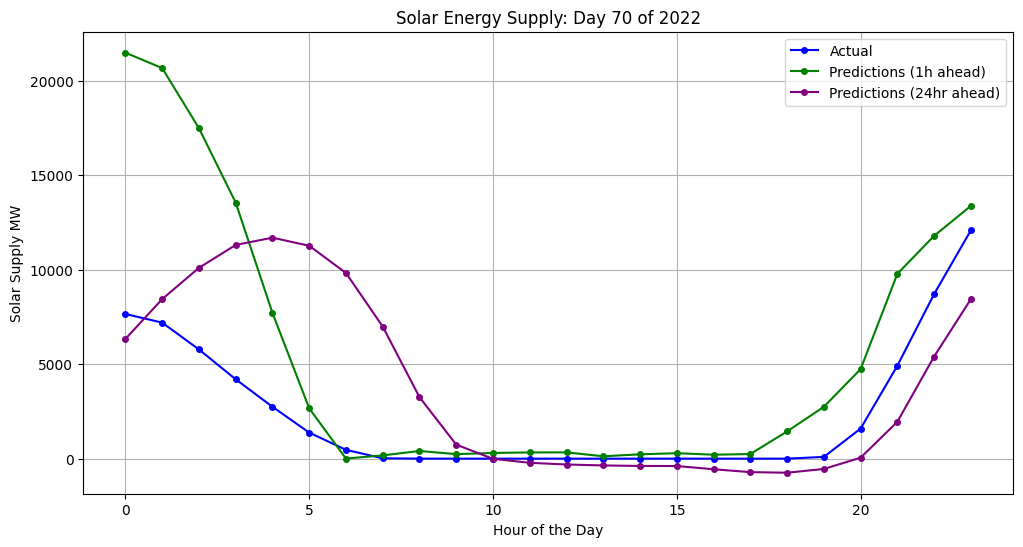

start_hour:  5229


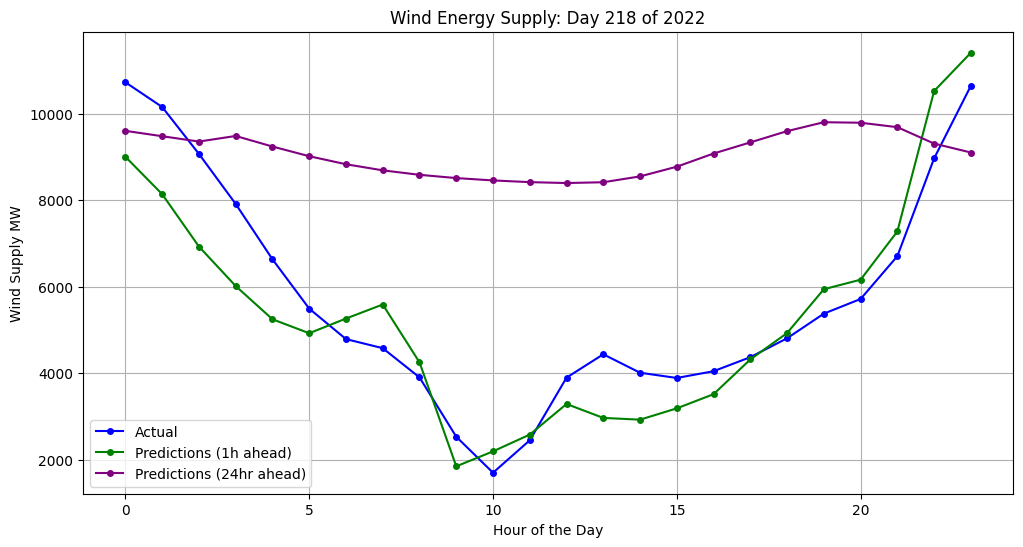

In [8]:
plot_day(output_1h_solar, output_24h_solar, target_1h_solar, "Solar")
plot_day(output_1h_wind, output_24h_wind, target_1h_wind, "Wind")


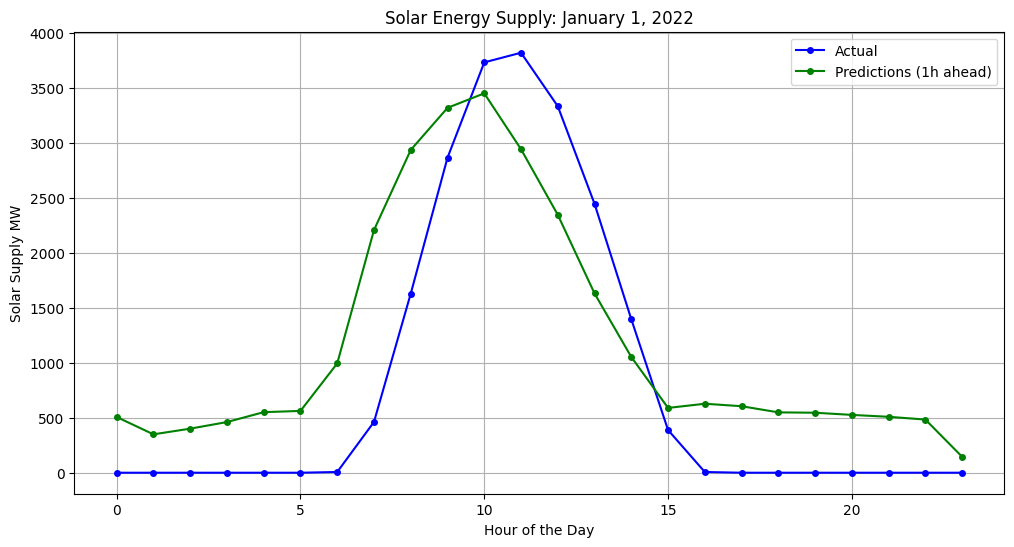

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_specific_day(output_1h, output_24h, target, subject, day_index):
    hours_per_day = 24
    sequence_length_1h = 25  # Sequence length for 1-hour predictions
    sequence_length_24h = 72  # Sequence length for 24-hour predictions

    plt.figure(figsize=(12, 6))

    # Calculate starting hour of the day for plotting (offset by the maximum sequence length to handle predictions)
    start_hour = day_index * hours_per_day - max(sequence_length_1h, sequence_length_24h)

    if start_hour < 0:
        raise ValueError("Starting hour for plotting falls before the start of the dataset")

    # Plot the target data for the selected day
    plt.plot(range(hours_per_day), target[start_hour + max(sequence_length_1h, sequence_length_24h):start_hour + max(sequence_length_1h, sequence_length_24h) + hours_per_day], "-o", color="b", label="Actual", markersize=4)
    # Plot 1-hour ahead predictions
    plt.plot(range(hours_per_day), output_1h[start_hour + sequence_length_1h:start_hour + sequence_length_1h + hours_per_day], "-o", color="g", label="Predictions (1h ahead)", markersize=4)
    # Plot 24-hour ahead predictions
    #plt.plot(range(hours_per_day), output_24h[start_hour + sequence_length_24h:start_hour + sequence_length_24h + hours_per_day], "-o", color="purple", label="Predictions (24hr ahead)", markersize=4)

    plt.legend()
    plt.title(f"{subject} Energy Supply: January 1, 2022")
    plt.xlabel("Hour of the Day")
    plt.ticklabel_format(axis="y", style="plain")
    plt.ylabel(f"{subject} Supply MW")
    plt.grid(True)
    #plt.savefig(f"plots/testing/{subject}_energy_supply_January_1_2022.png")
    plt.show()

# Call the function with the appropriate indices for January 1, 2022 (day_index = 0 since January 1 is the first day of the year)
plot_specific_day(output_1h_solar, output_24h_solar, target_1h_solar, "Solar", day_index=32)


In [10]:
def plot_week(output_1h, output_24h, target, subject):
    # Number of hours per week
    hours_per_week = 7 * 24

    # Adjust start hour for plotting from hour 24 to align all datasets
    # Reducing the maximum index calculation by 24 hours to accommodate the offset for synced data
    max_week_index = len(output_24h) - hours_per_week  # Use outputs_solar_24 length to define the week's limits

    # Select a random start hour from 24 to the maximum possible index that still allows for a full week of data
    start_hour = np.random.randint(24, max_week_index + 1)

    # Calculate the corresponding week number (for title purposes)
    week_number = (start_hour - 24) // hours_per_week + 1

    # Plot actual vs. predicted solar energy outputs for the selected week, starting from the 24th hour
    plt.figure(figsize=(12, 6))
    plt.plot(range(hours_per_week), target[start_hour:start_hour + hours_per_week], "-o", color="b", label="Actual", markersize=2)
    plt.plot(range(hours_per_week), output_1h[start_hour:start_hour + hours_per_week], "-o", color="g", label="Predictions (1h ahead)", markersize=2)
    plt.plot(range(hours_per_week), output_24h[start_hour :start_hour  + hours_per_week], "-o", color="purple", label="Predictions (24h ahead)", markersize=2)

    plt.legend()
    plt.title(f"{subject} Energy Supply: Week {week_number} of 2022")
    plt.xlabel("Hour of the Week")
    plt.ylabel(f"{subject} Supply MW")
    plt.grid(True)
    #plt.savefig(f"plots/testing/{subject}_energy_supply_week_{week_number}_window.png")
    plt.show()

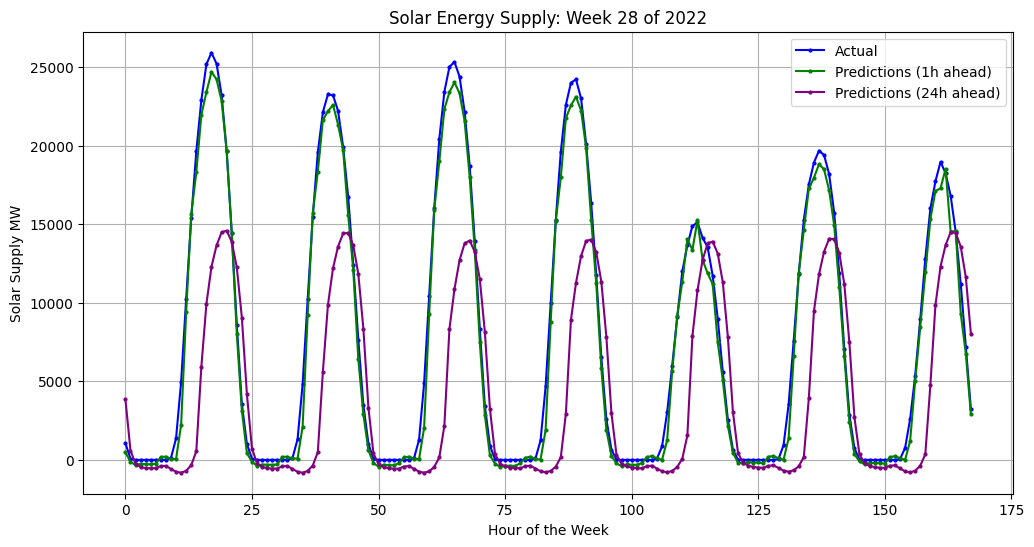

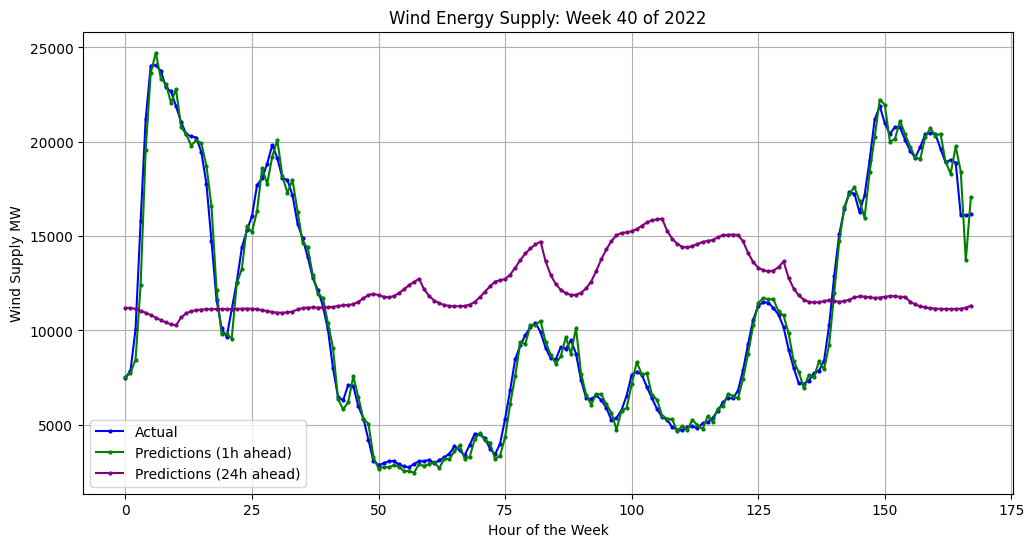

In [11]:
plot_week(output_1h_solar, output_24h_solar, target_1h_solar, "Solar")
plot_week(output_1h_wind, output_24h_wind, target_1h_wind, "Wind")

In [12]:
# Base timestamp
base_date = pd.Timestamp('2022-01-01 00:00')

# Generate a full range of hourly timestamps for the year 2022
timestamps = pd.date_range(start=base_date, periods=8760, freq='H')

In [13]:
# Calculate offsets
offset_1h = 25
offset_24h = 72+23

# Align the timestamps for each type of prediction
timestamps_1h = timestamps[offset_1h:]
timestamps_24h = timestamps[offset_24h:]

# For a random week starting Monday
week_start = np.random.choice(np.where(timestamps.weekday == 0)[0])
week_timestamps = timestamps[week_start:week_start + 7*24]  # 7 days * 24 hours

# For a random day
day_start = np.random.randint(0, len(timestamps) - 24)
day_timestamps = timestamps[day_start:day_start + 24]  # 24 hours


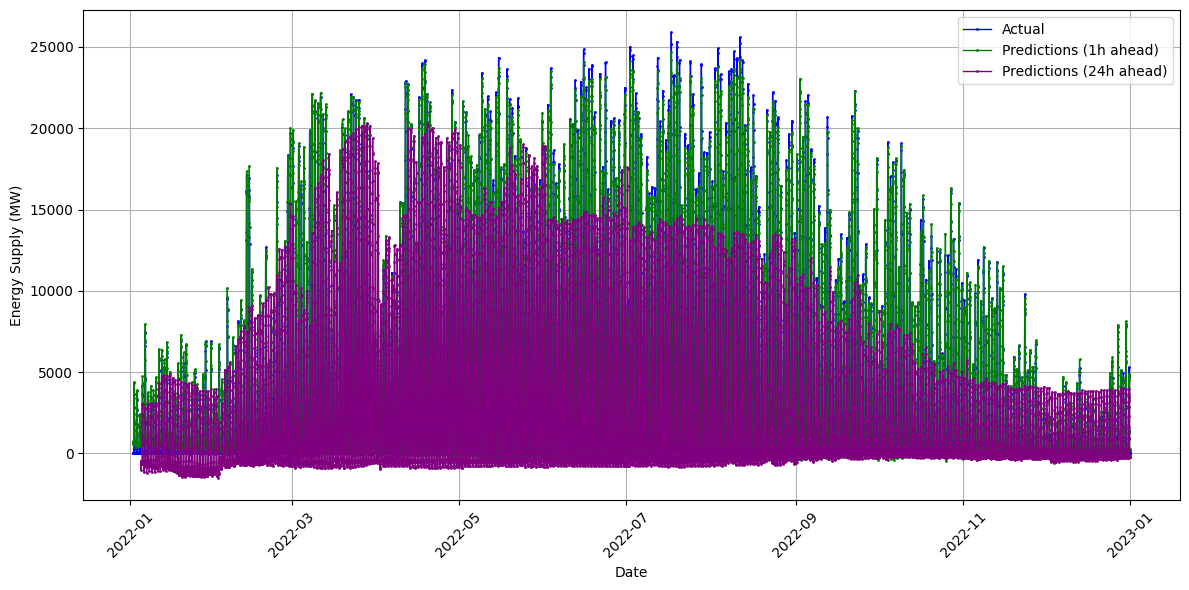

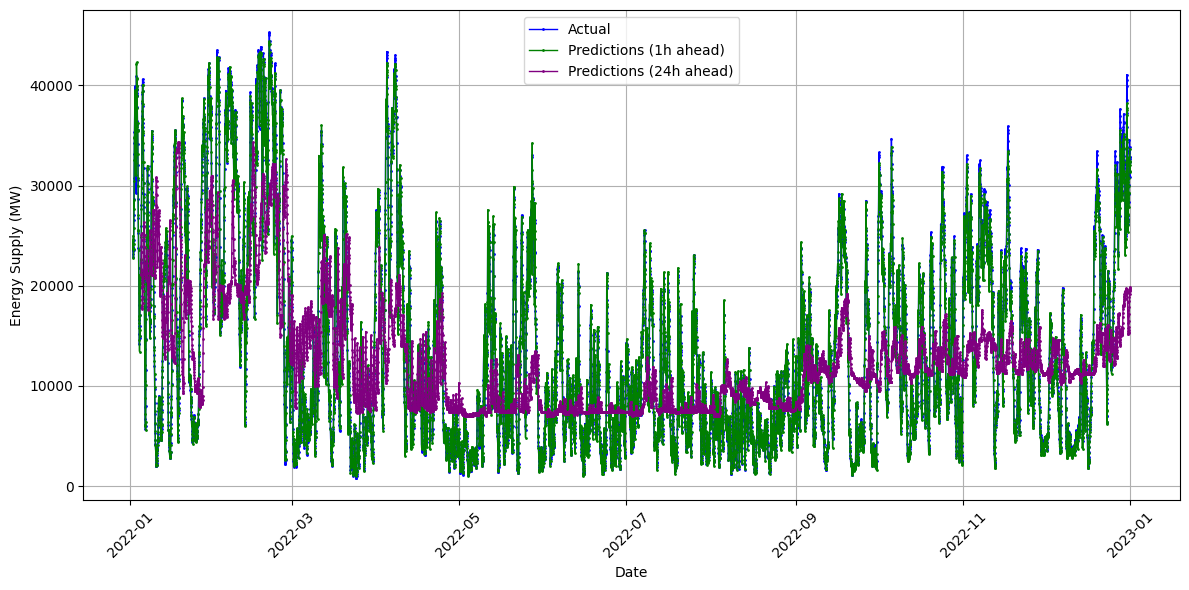

In [14]:
def plot_predictions(ts_1h, ts_24h, output_1h, output_24h, target_1h):
    plt.figure(figsize=(12, 6))
    plt.plot(ts_1h, target_1h, "-o", color="b", label="Actual", markersize=1, linewidth=1)
    plt.plot(ts_1h, output_1h, "-o", color="g", label="Predictions (1h ahead)", markersize=1, linewidth=1)
    plt.plot(ts_24h, output_24h, "-o", color="purple", label="Predictions (24h ahead)", markersize=1, linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Energy Supply (MW)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for Solar
plot_predictions(timestamps_1h, timestamps_24h, output_1h_solar, output_24h_solar, target_1h_solar)

# Plot for Wind
plot_predictions(timestamps_1h, timestamps_24h, output_1h_wind, output_24h_wind, target_1h_wind)


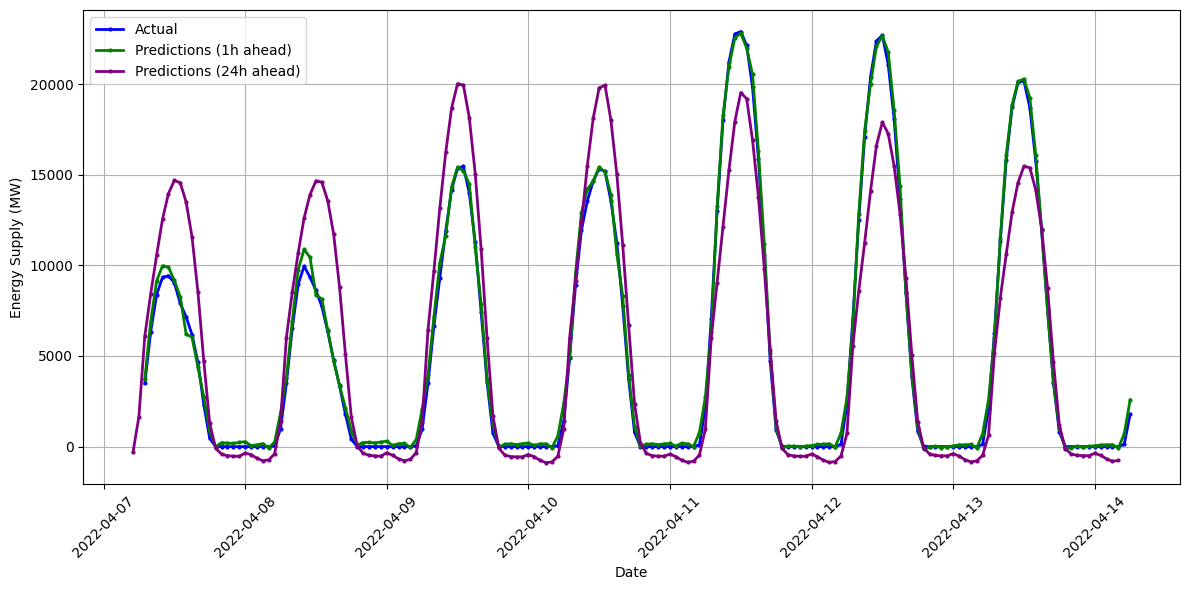

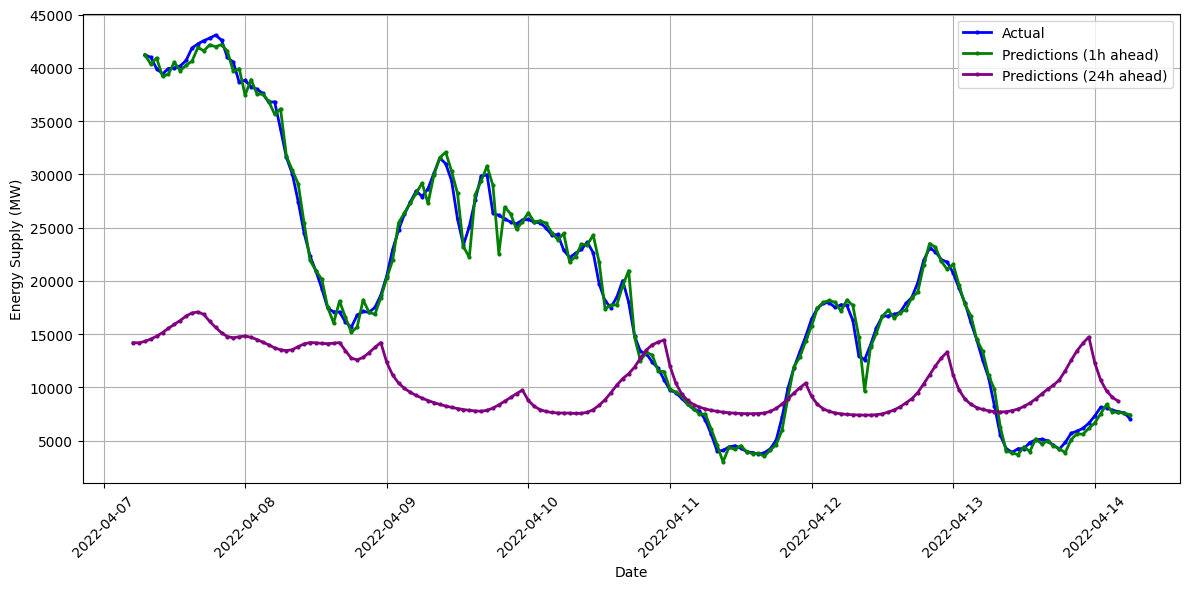

In [15]:
def plot_week_predictions(timestamps, output_1h, output_24h, target_1h, week_start, offset_1h, offset_24h):
    # Define the time range for one week (168 hours)
    end_week = week_start + 168

    # Adjust start indices for plotting
    start_1h = week_start + offset_1h
    start_24h = week_start + offset_24h

    # Ensure we do not exceed the length of the dataset
    end_1h = min(start_1h + 168, len(output_1h) + offset_1h)
    end_24h = min(start_24h + 168, len(output_24h) + offset_24h)

    plt.figure(figsize=(12, 6))

    # Plot the data for the week
    plt.plot(timestamps[start_1h:end_1h], target_1h[start_1h-offset_1h:end_1h-offset_1h], "-o", color="b", label="Actual", markersize=2, linewidth=2)
    plt.plot(timestamps[start_1h:end_1h], output_1h[start_1h-offset_1h:end_1h-offset_1h], "-o", color="g", label="Predictions (1h ahead)", markersize=2, linewidth=2)
    plt.plot(timestamps[start_24h-73:end_24h-73], output_24h[start_24h-offset_24h:end_24h-offset_24h], "-o", color="purple", label="Predictions (24h ahead)", markersize=2, linewidth=2)

    # Setup plot titles and labels
   
    plt.xlabel('Date')
    plt.ylabel('Energy Supply (MW)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Choose a random week start that aligns with your data setup
week_start = np.random.choice(range(len(timestamps) - 168))

# Call the plotting function with correct indices
plot_week_predictions(timestamps, output_1h_solar, output_24h_solar, target_1h_solar, week_start, 25, 96)
plot_week_predictions(timestamps, output_1h_wind, output_24h_wind, target_1h_wind, week_start, 25, 96)

In [18]:
def plot_day_predictions(timestamps, output_1h, output_24h, target_1h, week_start, offset_1h, offset_24h):

    end_day = day_start + 24

    # Adjust start indices for plotting
    start_1h = day_start + offset_1h
    start_24h = day_start + offset_24h

    # Ensure we do not exceed the length of the dataset
    end_1h = min(start_1h + 24, len(output_1h) + offset_1h)
    end_24h = min(start_24h + 24, len(output_24h) + offset_24h)

    plt.figure(figsize=(12, 6))

    # Plot the data for the week
    plt.plot(timestamps[start_1h:end_1h], target_1h[start_1h-offset_1h:end_1h-offset_1h], "-o", color="b", label="Actual", markersize=1, linewidth=2)
    plt.plot(timestamps[start_1h:end_1h], output_1h[start_1h-offset_1h:end_1h-offset_1h], "-o", color="g", label="Predictions (1h ahead)", markersize=1, linewidth=2)
    plt.plot(timestamps[start_24h-73+2:end_24h-73+2], output_24h[start_24h-offset_24h:end_24h-offset_24h], "-o", color="purple", label="Predictions (24h ahead)", markersize=2)

    # Setup plot titles and labels
  
    plt.xlabel('Date')
    plt.ylabel('Energy Supply (MW)')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # set major ticks interval every hour
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # show only hour and minute
    
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()





day_start:  6869


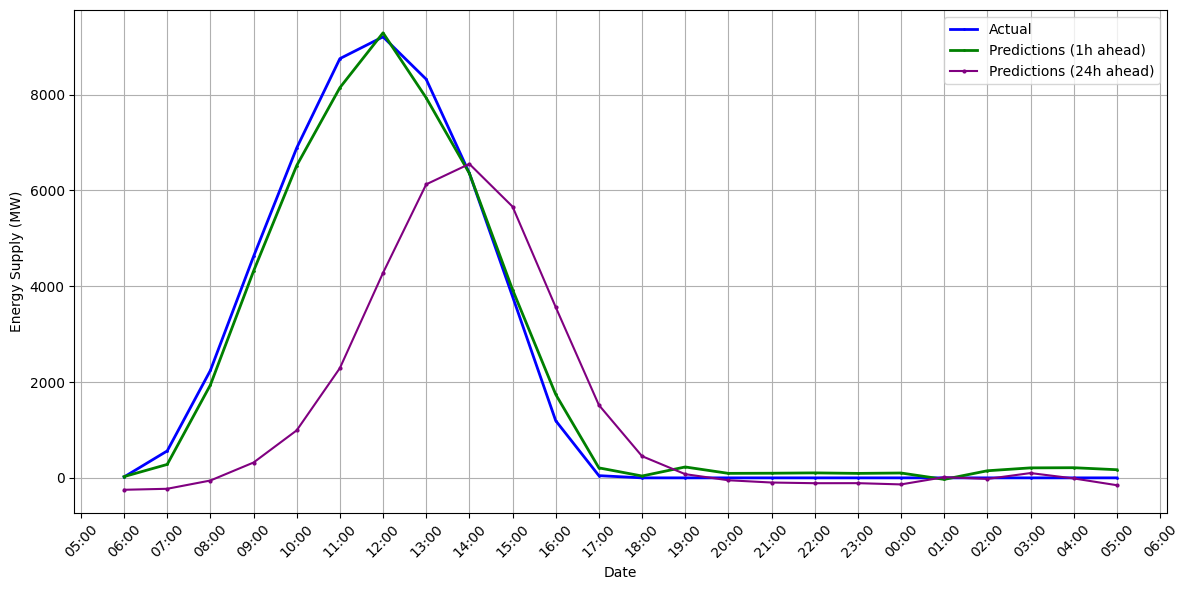

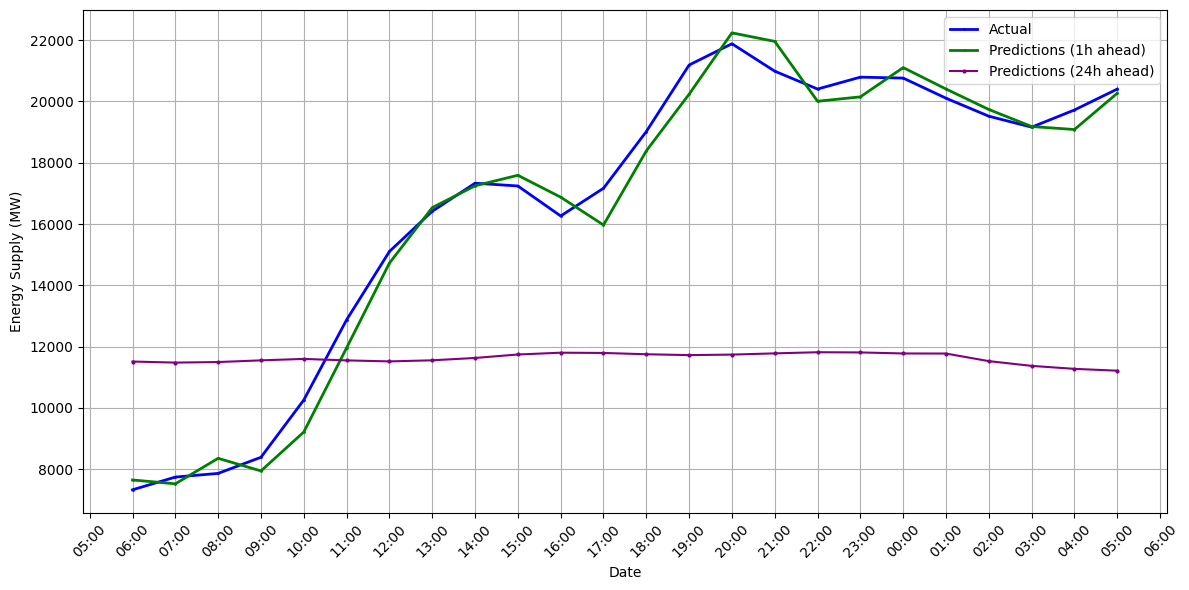

In [71]:
# Call the plotting function with correct indices
day_start = np.random.choice(range(len(timestamps) - 24))
print('day_start: ', day_start)
plot_day_predictions(timestamps, output_1h_solar, output_24h_solar, target_1h_solar, day_start, 25, 96)
plot_day_predictions(timestamps, output_1h_wind, output_24h_wind, target_1h_wind, day_start, 25, 96)